# Demography of duplicate genes

Arthur Zwaenepoel - August 2018

Assume a population of $N$ genes, residing happily in a genome. The genes duplicate at rate $\lambda$ (birth) and duplicates genes get lost at rate $\mu$ (death). We further assume that neo- or subfunctionalization leads to fixation of duplicate genes at rate $\phi$. Although this last assumption is not necessary to show the basic effects of continuous birth and death of duplicates through small-scale duplication events, it contributes some additional biological realism. Note that more sophisticated simulation studies can be found in Vanneste *et al.* (2013), where a similar model was combined with explicit simulation of synonymous sequence evolution and whole genome duplications.

This model was described first by Lynch & Conery (2003) and can be found more extensively in Lynch (2007). For discrete time, the expected number of duplicates of age $n_i$ turned can be shown to be given by

$$ \mathrm{log}(n_i) = \mathrm{log}(\lambda) + i \mathrm{log}(1-\mu) $$

Here I show a stochastic simulation of this model and some plots of the analytically derived expectations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
%matplotlib inline

In [112]:
"""
Draw a waiting time, assuming loss and fixation only operate on excess copies. While
duplication operates on all copies.
"""
def draw_waiting_time(lm, mu, ph, N, N_excess):
    rates_lf = ph + mu
    wt_d = rnd.expovariate(lm*N)
    if N_excess == 0:
        return wt_d, 2
    wt_lf = rnd.expovariate(rates_lf*N_excess)
    if wt_lf < wt_d:
        r = rnd.random()
        if r < ph/rates_lf:
            return wt_lf, 1
        else:
            return wt_lf, 0
    else:
        return wt_d, 2

In [102]:
def duplication_loss_simulation(N0=1000, lm=0.1, mu=0.1, t=1, ph=0.0):
    """
    Simulate the demography of duplicate genes, assuming constant birth & death rate 
    as well as a base number of genes. A rate of fixation of duplicates can also be
    specified.

    :param N0: number of base (initial, immortal) genes
    :param lm: birth (duplication) rate
    :param mu: death (loss) rate
    :param t: evolutionary time
    :param ph: fixation rate of duplicates
    :return: (duplicates, base population size, total population size) 
    """
    N = N0  # start with N0 genes
    population = []  # this stores all non-essential duplicates in the population and their age
    fixed = []  # this stores all fixed duplicates and their age

    # the waiting time until the first event is an exponentially distributed
    # variable with rate the sum of the rates x the number of genes
    waiting_time, event = draw_waiting_time(lm, mu, ph, N, 0)
    t -= waiting_time
    
    # loop until the desired time has passed
    while t > 0:    
        r = rnd.random()
        
        # fixation, inccrements N0 and moves a gene from population to fixed
        if event == 1:
            fixed_gene = population.pop(rnd.randrange(len(population)))
            fixed.append(fixed_gene)
            N0 += 1
            
        # duplication
        elif event == 2:
            population.append(0.0)
            N += 1
            
        # loss 
        elif N > N0 and event == 0:
            population.pop(rnd.randrange(len(population)))
            N -= 1
            
        # increment age of all duplicates in the population
        for i in range(len(population)):
            population[i] += waiting_time
            
        # increment age of all fixed duplicates
        for i in range(len(fixed)):
            fixed[i] += waiting_time
            
        # draw next waiting time
        waiting_time, event = draw_waiting_time(lm, mu, ph, N, len(population))
        t -= waiting_time
    
    return population + fixed, N, N0

In [105]:
lm, mu, ph = 0.005, 0.08, 0.001
pop, N, N0 = duplication_loss_simulation(N0=20000, lm=lm, mu=mu, ph=ph, t=100)
N0, N, len(pop)

(20117, 21436, 1436)

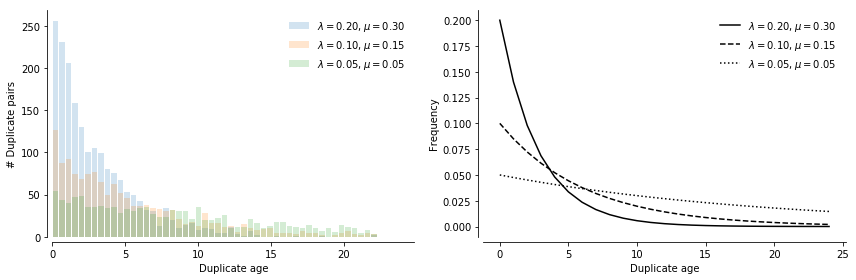

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

ax = axes[0]
# human
# lm, mu, ph = 0.005, 0.08, 0.001
lm, mu, ph = 0.2, 0.3, 0
pop, N, N0 = duplication_loss_simulation(N0=1000, lm=lm, mu=mu, ph=ph, t=25)
N0, N, len(pop)
bins, edges = np.histogram(pop, bins=50)
ax.hist(pop, bins=edges, alpha=0.2, rwidth=0.8, label="$\lambda = 0.20, \mu = 0.30$")

lm, mu, ph = 0.1, 0.15, 0
pop, N, N0 = duplication_loss_simulation(N0=1000, lm=lm, mu=mu, ph=ph, t=25)
N0, N, len(pop)
ax.hist(pop, bins=edges, alpha=0.2, rwidth=0.8, label="$\lambda = 0.10, \mu = 0.15$")

lm, mu, ph = 0.05, 0.05, 0
pop, N, N0 = duplication_loss_simulation(N0=1000, lm=lm, mu=mu, ph=ph, t=25)
N0, N, len(pop)
ax.hist(pop, bins=edges, alpha=0.2, rwidth=0.8, label="$\lambda = 0.05, \mu = 0.05$")

# plot aesthetics
ax.set_xlim(0, max(pop))
ax.set_xlabel("Duplicate age")
ax.set_ylabel("# Duplicate pairs")
ax.legend(frameon=False)


ax = axes[1]
lm, mu = 0.2, 0.3
ax.plot([lm*np.exp(i*np.log(1-mu)) for i in range(25)], color="k", label="$\lambda = 0.20, \mu = 0.30 $")
lm, mu = 0.1, 0.15
ax.plot([lm*np.exp(i*np.log(1-mu)) for i in range(25)], color="k", linestyle="--", label="$\lambda = 0.10, \mu = 0.15$")
lm, mu = 0.05, 0.05
ax.plot([lm*np.exp(i*np.log(1-mu)) for i in range(25)], color="k", linestyle=":", label="$\lambda = 0.05, \mu = 0.05$")
ax.set_xlabel("Duplicate age")
ax.set_ylabel("Frequency")

ax.legend(frameon=False)
sns.despine(offset=5)

fig.tight_layout()
#fig.savefig("ssd_simulation.png", dpi = 300)